## RL agent that is always actively providing liquidity and is adjusting his range 

In [1]:
# !pip install stable-baselines3 --default-timeout=100

In [2]:
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from env_always_active_tick_range import UniswapV3LPGymEnv
from config.env_config import Config

import gymnasium as gym
from gymnasium.wrappers import TimeLimit, RecordEpisodeStatistics, FlattenObservation
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt

np.random.seed(42)

TOTAL_TIMESTEPS      = 3000    # training steps
MAX_EPISODE_MINUTES  = 200    # one‑day cap

def make_env():
    cfg = Config()
    env = UniswapV3LPGymEnv(cfg, feat_num=19)

    env = TimeLimit(env, max_episode_steps=MAX_EPISODE_MINUTES)
    env = RecordEpisodeStatistics(env)
    env = FlattenObservation(env)

    logs_dir = Path("logs");  logs_dir.mkdir(exist_ok=True)
    env = Monitor(env, str(logs_dir), allow_early_resets=True)   
    return env


def plot_learning_curve(monitor_csv: Path, title: str = "Learning curve") -> None:
    df = pd.read_csv(monitor_csv, skiprows=1, comment="#", on_bad_lines='skip')
    df["rolling_return"] = df["r"].rolling(window=20).mean()
    plt.figure(figsize=(8, 4))
    plt.plot(df["l"], df["rolling_return"])
    plt.xlabel("Episode"); plt.ylabel("Reward (20‑ep MA)")
    plt.title(title); plt.grid(True)
    plt.tight_layout(); plt.show()


def main():
    env = DummyVecEnv([make_env])

    model = PPO(
        "MlpPolicy",
        env,
        # n_steps     = 2048,
        n_steps       = 1000,
        batch_size    = 200,
        gae_lambda    = 0.95,
        gamma         = 0.999,
        learning_rate = 3e-3,
        clip_range    = 0.2,
        vf_coef       = 0.5,
        ent_coef      = 0.7,
        verbose       = 1,
        device="auto",
    )

    model.learn(total_timesteps=TOTAL_TIMESTEPS, progress_bar=False)

    ts = dt.datetime.now().strftime("%Y%m%d_%H%M")
    model_path = Path("models"); model_path.mkdir(exist_ok=True)
    fname = model_path / f"ppo_uniswap_{ts}"
    model.save(fname)
    print(f"\n  Saved model to {fname}.zip")

    mean_r, std_r = evaluate_policy(model, env, n_eval_episodes=10)
    print(f"Evaluation over 10 eps → mean ± std reward: {mean_r:.2f} ± {std_r:.2f}")

    monitors = sorted(Path("logs").glob("*.monitor.csv"))
    if monitors:
        plot_learning_curve(monitors[-1], title="PPO on Uniswap‑V3 LP env")
    else:
        print("No monitor file found ‑ nothing to plot.")


if __name__ == "__main__":  
    main()

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | -366     |
| time/              |          |
|    fps             | 10       |
|    iterations      | 1        |
|    time_elapsed    | 93       |
|    total_timesteps | 1000     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 200        |
|    ep_rew_mean          | -197       |
| time/                   |            |
|    fps                  | 10         |
|    iterations           | 2          |
|    time_elapsed         | 191        |
|    total_timesteps      | 2000       |
| train/                  |            |
|    approx_kl            | 0.04270985 |
|    clip_fraction        | 0.194      |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.98      |
|    explained_variance   | 0.000402   |
|    learning_rate        | 

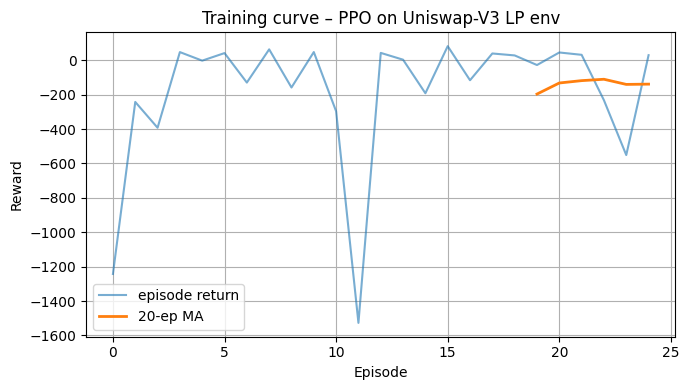

models/ppo_uniswap_20250701_0817.zip
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


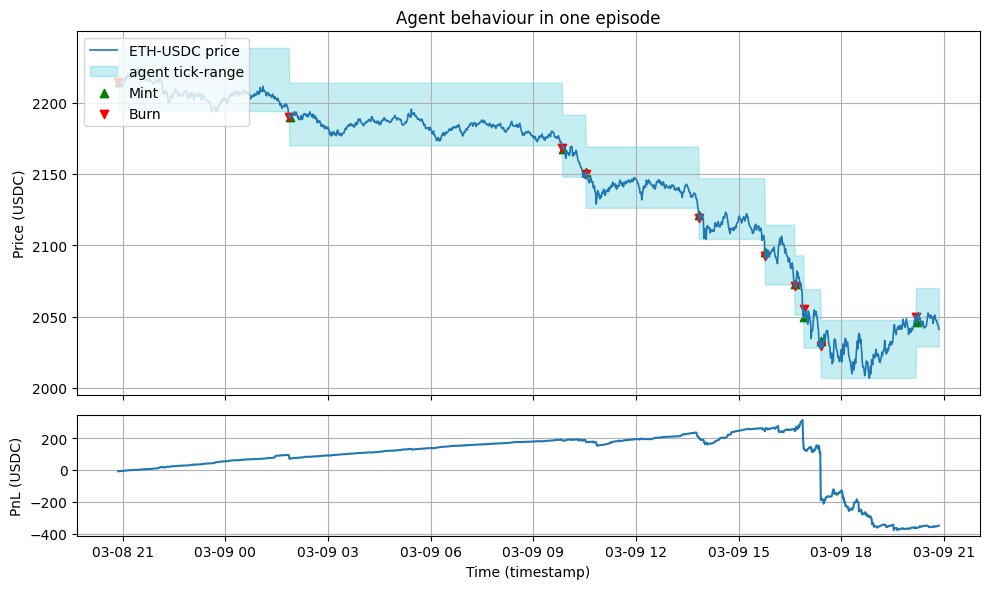

Raw actions from policy (shape (1440, 2)):
Actions array: [[10. 10.]
 [10. 10.]
 [10. 10.]
 ...
 [10. 10.]
 [10. 10.]
 [10. 10.]]


In [4]:

np.random.seed(42)

DECIMALS_TOKEN0, DECIMALS_TOKEN1 = 6, 18          
DEC_FACTOR = 10 ** (DECIMALS_TOKEN1 - DECIMALS_TOKEN0)  
def tick_to_price(tick: int | float) -> float:
    """Tick → dollar price (USDC per ETH)."""
    return DEC_FACTOR / (1.0001 ** tick)


def plot_learning_curve(log_dir: Path):
    """Plot episodic returns + 20-episode moving average."""
    mon_csv = sorted(log_dir.glob("monitor.csv"))[-1]
    df = pd.read_csv(mon_csv, comment="#")
    ep_returns = df["r"].to_numpy()
    ma = pd.Series(ep_returns).rolling(20).mean()

    plt.figure(figsize=(7, 4))
    plt.plot(ep_returns, label="episode return", alpha=0.6)
    plt.plot(ma, label="20-ep MA", linewidth=2)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.title("Training curve – PPO on Uniswap-V3 LP env")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def run_episode_and_plot(model, env):
    """Run one episode using the trained policy and plot agent behavior."""
    obs, _ = env.reset()

    prices, plow, phigh = [], [], []
    mints_x, mints_y, burns_x, burns_y = [], [], [], []
    cum_pnl = []
    actions_out = []
    timestamps = []
    

    done = False
    while not done:
        ts = env.decision_grid[env.idx]
        p = env._eth_price(ts)

        timestamps.append(ts)

        entering = env.entering

        action, _ = model.predict(obs, deterministic=True)
        actions_out.append(action.copy())

        obs, reward, done, _, _ = env.step(action)
        post_active = env.active

        prices.append(p)
        if post_active:
            plow.append(tick_to_price(env.tick_l))
            phigh.append(tick_to_price(env.tick_u))
        else:
            plow.append(np.nan)
            phigh.append(np.nan)


        if entering:
            mints_x.append(ts)
            mints_y.append(p)

            burns_x.append(ts - pd.Timedelta(minutes=1))
            burns_y.append(env._eth_price(ts - pd.Timedelta(minutes=1)))

        cum_pnl.append(env.cumulative_pnl)

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True,
                            gridspec_kw={"height_ratios": [3, 1]})

    axs[0].plot(timestamps, prices, label="ETH-USDC price", linewidth=1.2)
    axs[0].fill_between(timestamps, plow, phigh, color="tab:cyan", alpha=0.25,
                        label="agent tick-range")
    axs[0].scatter(mints_x, mints_y, marker="^", color="green", label="Mint")
    axs[0].scatter(burns_x, burns_y, marker="v", color="red", label="Burn")
    axs[0].set_ylabel("Price (USDC)")
    axs[0].set_title("Agent behaviour in one episode")
    axs[0].legend(loc="upper left")
    axs[0].grid(True)

    axs[1].plot(timestamps, cum_pnl, label="cumulative PnL")
    axs[1].set_ylabel("PnL (USDC)")
    axs[1].set_xlabel("Time (timestamp)")
    axs[1].grid(True)

    plt.tight_layout()
    plt.savefig("images/rebalancing_hedged_agent1.png", dpi=300, bbox_inches='tight')
    plt.show()

    actions_arr = np.array(actions_out)
    print(f"Raw actions from policy (shape {actions_arr.shape}):")
    np.set_printoptions(precision=3, suppress=True)
    print("Actions array:", actions_arr)


if __name__ == "__main__":
    LOG_DIR = Path("logs")
    MODEL_DIR = Path("models")

    plot_learning_curve(LOG_DIR)

    latest_model = sorted(MODEL_DIR.glob("ppo_uniswap_*.zip"))[-1]
    print(latest_model)
    from stable_baselines3 import PPO
    from env_always_active_tick_range import UniswapV3LPGymEnv
    from config.env_config import Config

    env = UniswapV3LPGymEnv(Config(), feat_num=19)
    env.EPISODE_LEN = 1440

    model = PPO.load(latest_model, env=env)
    run_episode_and_plot(model, env)